<a href="https://colab.research.google.com/github/surajbhala/GenAI/blob/main/Building_multi_user_React_Agent_in_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.5 MB/s eta 0:00:00


In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter your OpenAI key: ')


Enter your OpenAI key: ··········


## Tavily\


In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key : ')

Enter Tavily Search API Key : ··········


In [4]:
WEATHER_API_KEY = getpass('Enter WeatherAPI key :')

Enter WeatherAPI key :··········


In [5]:
import os
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY


In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results = 3, search_depth = 'advanced',
                                max_tokens = 10000)

@tool
def search_web(query:str) -> list:
  """Search the web for a query"""
  tavily_tool = TavilySearchResults(max_result = 2)
  results = tavily_tool.invoke(query)
  return results


@tool
def get_weather(query: str) -> list:
  """Get the weather for a location"""
  base_url = "https://api.weatherapi.com/v1/current.json"
  complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"
  response = requests.get(complete_url)
  data = response.json

  if data.get("location"):
    return data
  else:
    return "weather data not found"

### Test Tool Calling with LLM

In [7]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model = 'gpt-3.5-turbo', temperature = 0.0, openai_api_key = OPENAI_KEY)
tools = [search_web,get_weather]

chatgpt_with_tools = chatgpt.bind_tools(tools = tools)


In [8]:
prompt = "who won the champions league in 2024"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'search_web',
  'args': {'query': 'Champions League winner 2024'},
  'id': 'call_KSk6VAkmqZkZsFSYudzOJAja',
  'type': 'tool_call'}]

In [9]:
prompt= "how is the weather in Pune today?"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'get_weather',
  'args': {'query': 'Pune'},
  'id': 'call_W3ytn4oT0y8KuIxG3jufQLl2',
  'type': 'tool_call'}]

### Build and Test AI Agent with LangGraph Pre-built Agent

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

SYS_PROMPT = """Act as a helpful assistant.
                Use the tolls at your disposal to perform tasks as needed.
                 - get_weather : whenver user asks get the weather of a place
                 - search_web : whenver user asks search the web for a query
             """
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",SYS_PROMPT),
        MessagesPlaceholder(variable_name = "messages")
    ]
)

def add_sys_prompt(messages):
  return prompt_template.invoke({'messages': messages}).to_messages()

In [11]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(chatgpt, tools = tools,
                           messages_modifier=add_sys_prompt)

<ipython-input-11-fb95a732cab3>:3: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agent = create_react_agent(chatgpt, tools = tools,


### Visualizing agent architecture

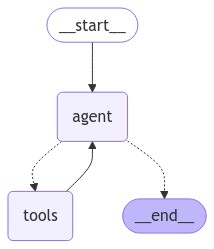

In [12]:
from IPython.display import Image,display

display(Image(agent.get_graph().draw_mermaid_png()))

In [13]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = agent.invoke({"messages": [('user', query)]})
response

{'messages': [HumanMessage(content='Tell me who won the champions league in 2024,\n            show some detailed information about the match also\n        ', additional_kwargs={}, response_metadata={}, id='c8d3fd87-0493-42ac-b274-99079d52f58f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_O6MBCq0cKC2c6Iwk6nkuM1wX', 'function': {'arguments': '{"query":"Champions League winner 2024"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 144, 'total_tokens': 164, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b66c7eb-0500-46ac-9321-f391d4e0bdd4-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Champions League winner 2024'}, 'id': 'call_O6MBCq0cKC2c

In [14]:
from IPython.display import display,Markdown

display(Markdown(response['messages'][-1].content))

Real Madrid won the Champions League in 2024. The final match was between Borussia Dortmund and Real Madrid at Wembley Stadium in London, UK. Real Madrid emerged victorious, winning the European Cup/Champions League final for the 15th time. The match took place on June 1, 2024, with Real Madrid securing the title. If you would like more detailed information about the match, please let me know.

In [15]:
query = """how is the weather in Pune, Maharashtra today?"""
response = agent.invoke({"messages": [('user', query)]},{"recursion_limit": 30})
response

{'messages': [HumanMessage(content='how is the weather in Pune, Maharashtra today?', additional_kwargs={}, response_metadata={}, id='c1d06a12-3ff9-4eef-9e4b-658210e50be7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OEbPkNomxS2n7oEe6BzgIFHp', 'function': {'arguments': '{"query":"Pune, Maharashtra"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-79ccd086-aebf-4193-ae3b-4114b8ff350a-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Pune, Maharashtra'}, 'id': 'call_OEbPkNomxS2n7oEe6BzgIFHp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17

In [16]:
display(Markdown(response["messages"][-1].content))

I found some information about the weather in Pune, Maharashtra today:

- The current temperature in Pune is 27.4°C with cloudy conditions.
- The wind speed is 11.2 km/h coming from the north-northeast direction.
- The humidity is at 59%.
- The visibility is 10.0 km.
- The UV index is 0.6.

For more detailed information, you can visit [Weather API](https://www.weatherapi.com/).

In [17]:
query = """What have we discussed so far"""
response = agent.invoke({"messages": [('user', query)]},{"recursion_limit": 30})
response

{'messages': [HumanMessage(content='What have we discussed so far', additional_kwargs={}, response_metadata={}, id='511f0282-6ae4-4749-8e26-3f1a6a93a754'),
  AIMessage(content='We have not discussed anything yet. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 127, 'total_tokens': 142, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-836263a1-b680-40e3-8b04-ad05faf1fa76-0', usage_metadata={'input_tokens': 127, 'output_tokens': 15, 'total_tokens': 142, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

In [18]:
display(Markdown(response["messages"][-1].content))

We have not discussed anything yet. How can I assist you today?

### The agent cannot remember conversations

In [19]:
##!rm memory.db*

In [ ]:
!pip install langgraph-checkpoint-sqlite

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

In [51]:
#with SqliteSaver.from_conn_string("memory.db") as memory:
#memory = SqliteSaver.from_conn_string("memory.db")
# agentic_chatbot = create_react_agent(chatgpt,tools = tools,
#                                      checkpointer = memory,
#                                      messages_modifier = add_sys_prompt)

def chat_with_agent(prompt:str,thread_id:str):

  with SqliteSaver.from_conn_string("memory.db") as memory:
    agentic_chatbot = create_react_agent(chatgpt, tools = tools, messages_modifier=add_sys_prompt, checkpointer=memory)
    thread = {"configurable": {"thread_id": "1"}}
    for event in agentic_chatbot.stream({"messages": prompt}, thread):
      for v in event.values():
          print(v['messages'])
    #response = agentic_chatbot.invoke({"messages":[("user",prompt)]},
     #                            {'configurable':{"thread_id":session_id}})
          display(Markdown(v['messages'][-1].content))
 # return response

In [52]:
user_id = 'ram001'
prompt = "who won the champions league in 2024"
chat_with_agent(prompt,user_id)

<ipython-input-51-531a6d6881ac>:10: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agentic_chatbot = create_react_agent(chatgpt, tools = tools, messages_modifier=add_sys_prompt, checkpointer=memory)


[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oKnv1n0hNij3ycoWh9n0stuA', 'function': {'arguments': '{"query":"Champions League winner 2024"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 130, 'total_tokens': 150, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6e14c6aa-2eaf-4010-8cb4-30bed890be8f-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Champions League winner 2024'}, 'id': 'call_oKnv1n0hNij3ycoWh9n0stuA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 20, 'total_tokens': 150, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]


[ToolMessage(content='[{"url": "https://www.uefa.com/uefachampionsleague/news/028e-1b07e18d875a-ba78e4b9d9fc-1000--real-madrid-win-champions-league-carvajal-and-vinicius-jun/", "content": "Live 01/06/2024 Champions League winners by nation Joselu became the 79th Spaniard to feature in a final win in 2024, with Jude Bellingham the 70th English player."}, {"url": "https://www.nbclosangeles.com/news/sports/soccer/real-madrid-wins-2024-champions-league-title/3426540/", "content": "Real Madrid defeated Borussia Dortmund at Wembley Stadium to win the 2024 Champions League title. ... As well as three titles with Madrid, he was a two-time winner with AC Milan. He also lifted"}, {"url": "https://www.sportingnews.com/us/champions-league/news/champions-league-final-2024-live-score-result-real-madrid-dortmund/0a034fd36e18781a619e15f1", "content": "Champions League final 2024 kick off time Borussia Dortmund vs. Real Madrid takes place at Wembley Stadium in London, UK and kicks off on Saturday, June

[{"url": "https://www.uefa.com/uefachampionsleague/news/028e-1b07e18d875a-ba78e4b9d9fc-1000--real-madrid-win-champions-league-carvajal-and-vinicius-jun/", "content": "Live 01/06/2024 Champions League winners by nation Joselu became the 79th Spaniard to feature in a final win in 2024, with Jude Bellingham the 70th English player."}, {"url": "https://www.nbclosangeles.com/news/sports/soccer/real-madrid-wins-2024-champions-league-title/3426540/", "content": "Real Madrid defeated Borussia Dortmund at Wembley Stadium to win the 2024 Champions League title. ... As well as three titles with Madrid, he was a two-time winner with AC Milan. He also lifted"}, {"url": "https://www.sportingnews.com/us/champions-league/news/champions-league-final-2024-live-score-result-real-madrid-dortmund/0a034fd36e18781a619e15f1", "content": "Champions League final 2024 kick off time Borussia Dortmund vs. Real Madrid takes place at Wembley Stadium in London, UK and kicks off on Saturday, June 1 at 8:00 p.m. local time."}, {"url": "https://www.nytimes.com/athletic/live-blogs/real-madrid-dortmund-live-updates-champions-league-final-2024-score-result/Ovn4uExc188E/", "content": "June 3, 2024 at 11:55 AM EDT. ... Real Madrid have won the European Cup/Champions League final for the 15th time (against just three losses), more than double every other team in history."}, {"url": "https://www.uefa.com/uefachampionsleague/news/028d-1ad799ae4525-365c9c4d1986-1000--real-madrid-win-the-2023-24-uefa-champions-league-meet-the/", "content": "Live 01/06/2024 Champions League final lowdown The best of the best will be crowned at London's Wembley Stadium on 1 June. Live 01/06/2024 Final records and statistics We open the final record"}]

[AIMessage(content='Real Madrid won the Champions League in 2024 by defeating Borussia Dortmund at Wembley Stadium.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 677, 'total_tokens': 699, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-90e569d1-6fc2-4eea-9e86-a81c2cb93af0-0', usage_metadata={'input_tokens': 677, 'output_tokens': 22, 'total_tokens': 699, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]


Real Madrid won the Champions League in 2024 by defeating Borussia Dortmund at Wembley Stadium.

In [53]:
prompt = "tell me more about this event please"
chat_with_agent(prompt,user_id)

<ipython-input-51-531a6d6881ac>:10: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agentic_chatbot = create_react_agent(chatgpt, tools = tools, messages_modifier=add_sys_prompt, checkpointer=memory)


[AIMessage(content="The 2024 Champions League final took place at Wembley Stadium in London, UK. Real Madrid emerged victorious by defeating Borussia Dortmund in the final match. This victory marked Real Madrid's 15th European Cup/Champions League title, solidifying their position as one of the most successful teams in the competition's history. The match was held on June 1, 2024, and Real Madrid secured the win to claim the prestigious title.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 713, 'total_tokens': 806, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b11c0392-74ca-49ff-90ba-795643871b7c-0', usage_metadata={'input_tokens': 713, 'output_tokens': 93, 'total_tokens': 806, 'input_token_details': {'cac

The 2024 Champions League final took place at Wembley Stadium in London, UK. Real Madrid emerged victorious by defeating Borussia Dortmund in the final match. This victory marked Real Madrid's 15th European Cup/Champions League title, solidifying their position as one of the most successful teams in the competition's history. The match was held on June 1, 2024, and Real Madrid secured the win to claim the prestigious title.

In [54]:
prompt = "who was the highest goal scorer in this match"
chat_with_agent(prompt,user_id)

<ipython-input-51-531a6d6881ac>:10: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agentic_chatbot = create_react_agent(chatgpt, tools = tools, messages_modifier=add_sys_prompt, checkpointer=memory)


[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bDSZ54LPhkpPpRboGM1jFJ9Z', 'function': {'arguments': '{"query":"highest goal scorer in Real Madrid vs Borussia Dortmund Champions League final 2024"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 822, 'total_tokens': 851, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-087a6878-c8e7-4d41-9d56-0db6a31fb0fe-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'highest goal scorer in Real Madrid vs Borussia Dortmund Champions League final 2024'}, 'id': 'call_bDSZ54LPhkpPpRboGM1jFJ9Z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 822, 'output_tokens': 29, 'total_tokens': 851, 'input_token_details'

[ToolMessage(content='[{"url": "https://www.uefa.com/uefachampionsleague/news/028e-1b07e18d875a-ba78e4b9d9fc-1000--real-madrid-win-champions-league-carvajal-and-vinicius-junior-see-off-dortmund/", "content": "Dani Carvajal and Vinícius Júnior scored the goals as Real Madrid overcame a spirited Borussia Dortmund 2-0 to win the 2024 UEFA Champions League final at Wembley Stadium. Key moments"}, {"url": "https://www.sportingnews.com/us/champions-league/news/real-madrid-vs-borussia-dortmund-live-score-result-updates-stats-ucl/b8012e1d1e84910357eefd0c", "content": "Real Madrid vs Borussia Dortmund final score: UCL result, stats as Vinicius hat-trick crowns amazing comeback | Sporting News Real Madrid vs Borussia Dortmund final score: UCL result, stats as Vinicius hat-trick crowns amazing comeback Real Madrid added to their frankly absurd catalogue of Champions League comebacks as Vinicius netted a sparkling hat-trick to down Borussia Dortmund 5-2. 45 mins before kickoff: It\'s easy to forge

[{"url": "https://www.uefa.com/uefachampionsleague/news/028e-1b07e18d875a-ba78e4b9d9fc-1000--real-madrid-win-champions-league-carvajal-and-vinicius-junior-see-off-dortmund/", "content": "Dani Carvajal and Vinícius Júnior scored the goals as Real Madrid overcame a spirited Borussia Dortmund 2-0 to win the 2024 UEFA Champions League final at Wembley Stadium. Key moments"}, {"url": "https://www.sportingnews.com/us/champions-league/news/real-madrid-vs-borussia-dortmund-live-score-result-updates-stats-ucl/b8012e1d1e84910357eefd0c", "content": "Real Madrid vs Borussia Dortmund final score: UCL result, stats as Vinicius hat-trick crowns amazing comeback | Sporting News Real Madrid vs Borussia Dortmund final score: UCL result, stats as Vinicius hat-trick crowns amazing comeback Real Madrid added to their frankly absurd catalogue of Champions League comebacks as Vinicius netted a sparkling hat-trick to down Borussia Dortmund 5-2. 45 mins before kickoff: It's easy to forget that Dortmund had chances to punish Madrid at Wembley before Dani Carvajal and Vinicius Jr. secured the trophy the last time these two teams met. *Real Madrid (4-3-3, right to left):* Courtois (GK) — Vazquez, Rudiger, Militao, Mendy — Valverde, Modric, Bellingham — Rodrygo, Mbappe, Vinicius"}, {"url": "https://www.bbc.com/sport/football/live/c70zpkxqe87t?page=6", "content": "This game will see Real Madrid and Borussia Dortmund meet for the first time since last season’s UEFA Champions League final, won 2-0 by the Madrid side at Wembley. Borussia Dortmund are the opponent that Real Madrid’s Kylian Mbappé has faced the most times in the UEFA Champions League (8) – after scoring three goals in his first two games against them (in 2016-17 for Monaco), he’s only netted once in the last six and failed to find the net in the last three. Since the start of last season, the two players with the most assists delivered in the UEFA Champions League are Real Madrid’s Jude Bellingham and Borussia Dortmund’s Marcel Sabitzer (five each)."}, {"url": "https://www.nytimes.com/athletic/live-blogs/real-madrid-dortmund-live-updates-champions-league-final-2024-score-result/Ovn4uExc188E/", "content": "Real Madrid won a 15th Champions League title after withstanding a hugely impressive Borussia Dortmund performance to triumph at Wembley thanks to late goals from Dani Carvajal and Vinicius Junior."}, {"url": "https://www.nytimes.com/athletic/5532520/2024/06/01/borussia-dortmund-real-madrid-champions-league-final/", "content": "Real Madrid won a 15th Champions League title after withstanding a hugely impressive Borussia Dortmund performance to triumph at Wembley thanks to late goals from Dani Carvajal and Vinicius Junior"}]

[AIMessage(content='In the 2024 Champions League final between Real Madrid and Borussia Dortmund, Dani Carvajal and Vinícius Júnior were the goal scorers for Real Madrid. Vinícius Júnior had a significant impact on the match by scoring crucial goals to help Real Madrid secure the victory.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 1590, 'total_tokens': 1655, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-dca4f5bf-ac97-4b8e-8cb0-b2805377c70e-0', usage_metadata={'input_tokens': 1590, 'output_tokens': 65, 'total_tokens': 1655, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]


In the 2024 Champions League final between Real Madrid and Borussia Dortmund, Dani Carvajal and Vinícius Júnior were the goal scorers for Real Madrid. Vinícius Júnior had a significant impact on the match by scoring crucial goals to help Real Madrid secure the victory.

In [56]:
user_id = 'goa001'
prompt = "how is the weather in Pune, Maharashtra today?"
chat_with_agent(prompt,user_id)

<ipython-input-51-531a6d6881ac>:10: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agentic_chatbot = create_react_agent(chatgpt, tools = tools, messages_modifier=add_sys_prompt, checkpointer=memory)


[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oDoITILgmYpgkFRTf4kjmy9Z', 'function': {'arguments': '{"query":"Pune, Maharashtra"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 2037, 'total_tokens': 2054, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7759cee7-d8ca-4443-b734-56a095febcb2-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Pune, Maharashtra'}, 'id': 'call_oDoITILgmYpgkFRTf4kjmy9Z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2037, 'output_tokens': 17, 'total_tokens': 2054, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]


[ToolMessage(content='Error: AttributeError("\'function\' object has no attribute \'get\'")\n Please fix your mistakes.', name='get_weather', id='ed4985d6-7a5a-419b-a176-6fc35d22c03f', tool_call_id='call_oDoITILgmYpgkFRTf4kjmy9Z', status='error')]


Error: AttributeError("'function' object has no attribute 'get'")
 Please fix your mistakes.

[AIMessage(content='I encountered an error while trying to retrieve the weather information for Pune, Maharashtra. Let me try again.', additional_kwargs={'tool_calls': [{'id': 'call_So6otkoz4ROJNgQxIErMrvHG', 'function': {'arguments': '{"query":"Pune, Maharashtra"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 2080, 'total_tokens': 2119, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dafdb0ad-855e-4266-8c79-c7093b1e0d5a-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Pune, Maharashtra'}, 'id': 'call_So6otkoz4ROJNgQxIErMrvHG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2080, 'output_tokens': 39, 'total_tokens': 2119, 'input_token_details': {'cache_read

I encountered an error while trying to retrieve the weather information for Pune, Maharashtra. Let me try again.

[ToolMessage(content='Error: AttributeError("\'function\' object has no attribute \'get\'")\n Please fix your mistakes.', name='get_weather', id='1d28e948-e58b-489d-a788-c1b33b945d97', tool_call_id='call_So6otkoz4ROJNgQxIErMrvHG', status='error')]


Error: AttributeError("'function' object has no attribute 'get'")
 Please fix your mistakes.

[AIMessage(content='I apologize for the inconvenience. It seems there is an issue with retrieving the weather information for Pune, Maharashtra at the moment. Let me attempt to get the weather data again.', additional_kwargs={'tool_calls': [{'id': 'call_pcM813AeIyDJCbLj6RnHtA1t', 'function': {'arguments': '{"query":"Pune, Maharashtra"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 2148, 'total_tokens': 2201, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-03852ad4-40ef-4bf0-949d-6abae1d7caa7-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Pune, Maharashtra'}, 'id': 'call_pcM813AeIyDJCbLj6RnHtA1t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2148, 'outpu

I apologize for the inconvenience. It seems there is an issue with retrieving the weather information for Pune, Maharashtra at the moment. Let me attempt to get the weather data again.

[ToolMessage(content='Error: AttributeError("\'function\' object has no attribute \'get\'")\n Please fix your mistakes.', name='get_weather', id='2ae47113-dde1-4b52-b66e-cdd0c0358e70', tool_call_id='call_pcM813AeIyDJCbLj6RnHtA1t', status='error')]


Error: AttributeError("'function' object has no attribute 'get'")
 Please fix your mistakes.

[AIMessage(content="I'm currently facing a technical issue in retrieving the weather information for Pune, Maharashtra. I'll make another attempt to get the weather data.", additional_kwargs={'tool_calls': [{'id': 'call_hivkgEmVznDAK3yqJpm8W8tI', 'function': {'arguments': '{"query": "Pune, Maharashtra"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_6cMiQzXjmwzr6K1f9TvQrR9T', 'function': {'arguments': '{"query": "weather forecast Pune, Maharashtra"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 2230, 'total_tokens': 2309, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9e19cd34-cd34-47b5-a6fd-f74251a5387f-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 

I'm currently facing a technical issue in retrieving the weather information for Pune, Maharashtra. I'll make another attempt to get the weather data.

[ToolMessage(content='Error: AttributeError("\'function\' object has no attribute \'get\'")\n Please fix your mistakes.', name='get_weather', id='403f9c49-0924-41bc-a891-351abafcab2c', tool_call_id='call_hivkgEmVznDAK3yqJpm8W8tI', status='error'), ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'Pune\', \'region\': \'Maharashtra\', \'country\': \'India\', \'lat\': 18.5333, \'lon\': 73.8667, \'tz_id\': \'Asia/Kolkata\', \'localtime_epoch\': 1730368880, \'localtime\': \'2024-10-31 15:31\'}, \'current\': {\'last_updated_epoch\': 1730368800, \'last_updated\': \'2024-10-31 15:30\', \'temp_c\': 27.4, \'temp_f\': 81.4, \'is_day\': 1, \'condition\': {\'text\': \'Cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/119.png\', \'code\': 1006}, \'wind_mph\': 6.9, \'wind_kph\': 11.2, \'wind_degree\': 31, \'wind_dir\': \'NNE\', \'pressure_mb\': 1010.0, \'pressure_in\': 29.82, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 59, \'clou

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Pune', 'region': 'Maharashtra', 'country': 'India', 'lat': 18.5333, 'lon': 73.8667, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1730368880, 'localtime': '2024-10-31 15:31'}, 'current': {'last_updated_epoch': 1730368800, 'last_updated': '2024-10-31 15:30', 'temp_c': 27.4, 'temp_f': 81.4, 'is_day': 1, 'condition': {'text': 'Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/119.png', 'code': 1006}, 'wind_mph': 6.9, 'wind_kph': 11.2, 'wind_degree': 31, 'wind_dir': 'NNE', 'pressure_mb': 1010.0, 'pressure_in': 29.82, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 59, 'cloud': 67, 'feelslike_c': 28.8, 'feelslike_f': 83.9, 'windchill_c': 27.4, 'windchill_f': 81.4, 'heatindex_c': 28.8, 'heatindex_f': 83.9, 'dewpoint_c': 18.7, 'dewpoint_f': 65.7, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.6, 'gust_mph': 10.6, 'gust_kph': 17.0}}"}, {"url": "https://www.qweather.com/en/weather30d/pune-3655B.html", "content": "28°~13°. High. Low. 2024-10-28. 18°~33°. 9km/h. WNW. 0.0mm. Pune 30 days forecast, weather trend in the next 30 days, also 30 days precipitation forecast and Pune travel weather forecast."}, {"url": "https://www.hindustantimes.com/cities/pune-news/pune-weather-today-aqi-and-rain-forecast-updates-october-31-2024-101730338223060.html", "content": "The temperature in Pune today, on October 31, 2024, is 28.73 °C. The day's forecast indicates a minimum and maximum temperature of 23.84 °C and 31.77 °C, respectively. The relative humidity is"}, {"url": "https://www.easeweather.com/asia/india/maharashtra/pune-division/pune/october", "content": "Until now, October 2024 in Pune is slightly cooler than the historical average by -0.7 ° C.. The forecast for the next days in Pune predicts temperatures to be around 31 ° C, close to the historical average.. In general, the average temperature in Pune at the beginning of October is 29.4 ° C.As the month progressed, temperatures tended to moderately rise, reaching an average of 30.6 ° C by"}, {"url": "https://www.timeanddate.com/weather/india/pune/hourly", "content": "Hour-by-Hour Forecast for Pune, Maharashtra, India. Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 89 °F. Scattered clouds. (Weather station: Pune, India). See more current weather."}]

[AIMessage(content='The current weather in Pune, Maharashtra is as follows:\n- Temperature: 27.4°C (81.4°F)\n- Condition: Cloudy\n- Wind: 11.2 km/h from NNE\n- Humidity: 59%\n- Feels like: 28.8°C (83.9°F)\n- Visibility: 10.0 km\n- UV Index: 0.6\n\nFor more detailed weather information and forecasts, you can visit reliable weather websites like WeatherAPI, QWeather, Hindustan Times, EaseWeather, or Time and Date.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 3201, 'total_tokens': 3321, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-295be0ba-3156-4ff6-9aaa-99c293680237-0', usage_metadata={'input_tokens': 3201, 'output_tokens': 120, 'total_tokens': 3321, 'input_token_details': {'cache_read': 0}, 'output_toke

The current weather in Pune, Maharashtra is as follows:
- Temperature: 27.4°C (81.4°F)
- Condition: Cloudy
- Wind: 11.2 km/h from NNE
- Humidity: 59%
- Feels like: 28.8°C (83.9°F)
- Visibility: 10.0 km
- UV Index: 0.6

For more detailed weather information and forecasts, you can visit reliable weather websites like WeatherAPI, QWeather, Hindustan Times, EaseWeather, or Time and Date.

In [57]:
prompt = "how does it look for 10 days ahead"
chat_with_agent(prompt,user_id)

<ipython-input-51-531a6d6881ac>:10: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agentic_chatbot = create_react_agent(chatgpt, tools = tools, messages_modifier=add_sys_prompt, checkpointer=memory)


[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cIykLIER3Q9UlJQ1I1KZfSWH', 'function': {'arguments': '{"query":"weather forecast Pune, Maharashtra 10 days"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 3337, 'total_tokens': 3358, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-13496f94-29b5-43c6-bbbf-cb97cf81baaa-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'weather forecast Pune, Maharashtra 10 days'}, 'id': 'call_cIykLIER3Q9UlJQ1I1KZfSWH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3337, 'output_tokens': 21, 'total_tokens': 3358, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]


[ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'Pune\', \'region\': \'Maharashtra\', \'country\': \'India\', \'lat\': 18.5333, \'lon\': 73.8667, \'tz_id\': \'Asia/Kolkata\', \'localtime_epoch\': 1730368880, \'localtime\': \'2024-10-31 15:31\'}, \'current\': {\'last_updated_epoch\': 1730368800, \'last_updated\': \'2024-10-31 15:30\', \'temp_c\': 27.4, \'temp_f\': 81.4, \'is_day\': 1, \'condition\': {\'text\': \'Cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/119.png\', \'code\': 1006}, \'wind_mph\': 6.9, \'wind_kph\': 11.2, \'wind_degree\': 31, \'wind_dir\': \'NNE\', \'pressure_mb\': 1010.0, \'pressure_in\': 29.82, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 59, \'cloud\': 67, \'feelslike_c\': 28.8, \'feelslike_f\': 83.9, \'windchill_c\': 27.4, \'windchill_f\': 81.4, \'heatindex_c\': 28.8, \'heatindex_f\': 83.9, \'dewpoint_c\': 18.7, \'dewpoint_f\': 65.7, \'vis_km\': 10.0, \'vis_miles\': 6.0, \'uv\': 0.6, \'gus

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Pune', 'region': 'Maharashtra', 'country': 'India', 'lat': 18.5333, 'lon': 73.8667, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1730368880, 'localtime': '2024-10-31 15:31'}, 'current': {'last_updated_epoch': 1730368800, 'last_updated': '2024-10-31 15:30', 'temp_c': 27.4, 'temp_f': 81.4, 'is_day': 1, 'condition': {'text': 'Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/119.png', 'code': 1006}, 'wind_mph': 6.9, 'wind_kph': 11.2, 'wind_degree': 31, 'wind_dir': 'NNE', 'pressure_mb': 1010.0, 'pressure_in': 29.82, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 59, 'cloud': 67, 'feelslike_c': 28.8, 'feelslike_f': 83.9, 'windchill_c': 27.4, 'windchill_f': 81.4, 'heatindex_c': 28.8, 'heatindex_f': 83.9, 'dewpoint_c': 18.7, 'dewpoint_f': 65.7, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.6, 'gust_mph': 10.6, 'gust_kph': 17.0}}"}, {"url": "https://weather.com/en-IN/weather/tenday/l/de358cca466f4edf4b74ac43b04bd12422a8bc9c90eb9d29539390a8d77da8fc", "content": "31°/ 20°. 5%. Partly cloudy. Hazy. Low 20°C. Winds E and variable. Be prepared with the most accurate 10-day forecast for Pune, Maharashtra with highs, lows, chance of precipitation from The"}, {"url": "https://www.weather-india.in/en/india/maharashtra/weather-pune/10-day-forecast", "content": "28°C. Clear sky. 0 mm. E 9 km/h. Clear sky. Rain 0 mm, Wind 9 km/h, Wind direction E. Weather in Pune, Maharashtra in the next 10 days? We provide information on: wind speed, wind direction, atmospheric pressure, temperature, humidity and visibility."}, {"url": "https://www.easeweather.com/asia/india/maharashtra/pune-division/pune/october", "content": "Until now, October 2024 in Pune is slightly cooler than the historical average by -0.7 ° C.. The forecast for the next days in Pune predicts temperatures to be around 31 ° C, close to the historical average.. In general, the average temperature in Pune at the beginning of October is 29.4 ° C.As the month progressed, temperatures tended to moderately rise, reaching an average of 30.6 ° C by"}, {"url": "https://www.easeweather.com/asia/india/maharashtra/pune-division/pune", "content": "Discover the latest weather forecast for Pune, featuring daily and 14-day long-range predictions. View detailed, interactive graphs and click for in-depth information on each day's weather in Pune. Units °C °F. Pune. Forecast Today Tomorrow. more. Maharashtra India United States. ... Thu. 31. 31 ° 24 ° 0.2 mm. Fri. 1. 32"}]

[AIMessage(content='The weather forecast for Pune, Maharashtra for the next 10 days indicates the following:\n- Temperature range: 31°C to 20°C\n- Conditions: Partly cloudy with hazy weather\n- Wind: East and variable\n- Chance of precipitation: 5%\n\nFor more detailed and specific daily forecasts, you can visit weather websites like The Weather Channel, Weather India, or EaseWeather.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 4220, 'total_tokens': 4301, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-70cd804b-09eb-486e-a0ec-32179faba630-0', usage_metadata={'input_tokens': 4220, 'output_tokens': 81, 'total_tokens': 4301, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

The weather forecast for Pune, Maharashtra for the next 10 days indicates the following:
- Temperature range: 31°C to 20°C
- Conditions: Partly cloudy with hazy weather
- Wind: East and variable
- Chance of precipitation: 5%

For more detailed and specific daily forecasts, you can visit weather websites like The Weather Channel, Weather India, or EaseWeather.